In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# 1D Poisson Equation

Source: - Lu, L., Pestourie, R., Johnson, S. G. & Romano, G. Multifidelity deep neural operators for efficient learning of partial differential equations with application to fast inverse design of nanoscale heat transport. Phys. Rev. Research 4, 023210 (2022).

$$
\frac{d^{2}u}{dx^{2}} = 20 f(x),   x \in [0,1],\\
$$
* with the Dirichlet boundary condition $u(0) = u(1) = 0$.
* The solution operator is given by:
$$
\mathcal{G} : f \mapsto u.\\
$$
* We sample $f$ from a Gaussian random field (GRF) with mean zero:
$$
f \sim \mathcal{GP}(0,k_{l}(x_1,x_2)),\\
k_{l}(x_1,x_2) = \exp \Big[-\frac{|x_1 - x_2|^2}{2l^2} \Big], l=0.05.\\
$$
* We generate the high-fidelity and low-fidelity data sets by solving the Poisson equation via the finite difference method with different mesh size $\Delta x$.
* For the high-fidelity solutions, we use $\Delta x = 1/99$, and for the low-fidelity solutions, $\Delta x = 1/9$.
* In the high-fidelity data set we have $500$ different samples of $f$ , but for each $f$ we do not have the full field observation of the corresponding solution $u$, and instead, we only know the value of $u(x)$ at one location $x$ randomly sampled in $[0, 1]$.
* All DeepONets are trained with an Adam optimizer, SELU activation function, with a learning rate $10^{−4}$ for $50000$ epochs. 
* We test DeepONets with different width, and the DeepONet with the width 5 has the smallest test mse.
* The mean and standard deviation of the error are obtained by ten runs with a randomly generated data set and random network initialization.

In [2]:
# Imports
from data.spaces import GRF, space_samples

# space = GRF(1, length_scale=0.2, N=1000, interp="cubic")
# space_samples(space, 1)

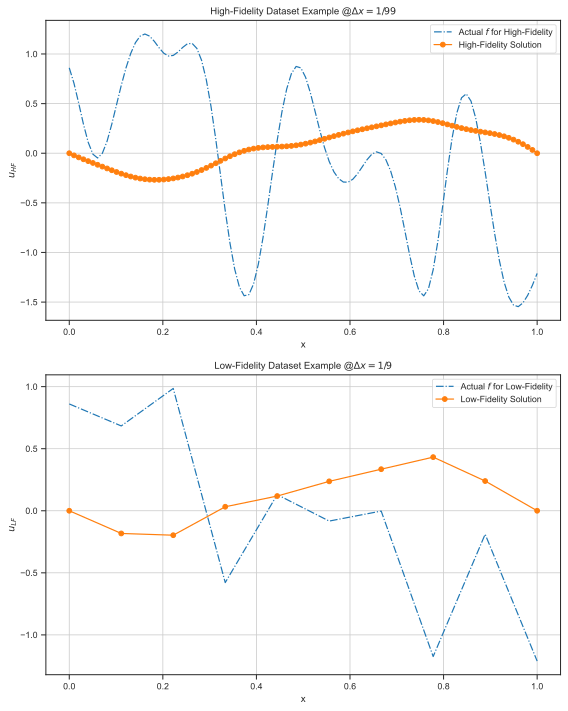

In [3]:
# Example of Low & High Fidelity Data
from data.poisson import example
example()

Generating operator data...


100%|██████████| 100000/100000 [00:50<00:00, 1983.88it/s]


Shape of f_{HF}: (100000, 100)
Shape of x_{HF}: (100000, 1)
Shape of u_{HF}: (100000, 1)

*************************************************



100%|██████████| 100000/100000 [00:26<00:00, 3787.53it/s]


Shape of f_{LF}: (100000, 10)
Shape of x_{LF}: (100000, 1)
Shape of u_{LF}: (100000, 100)


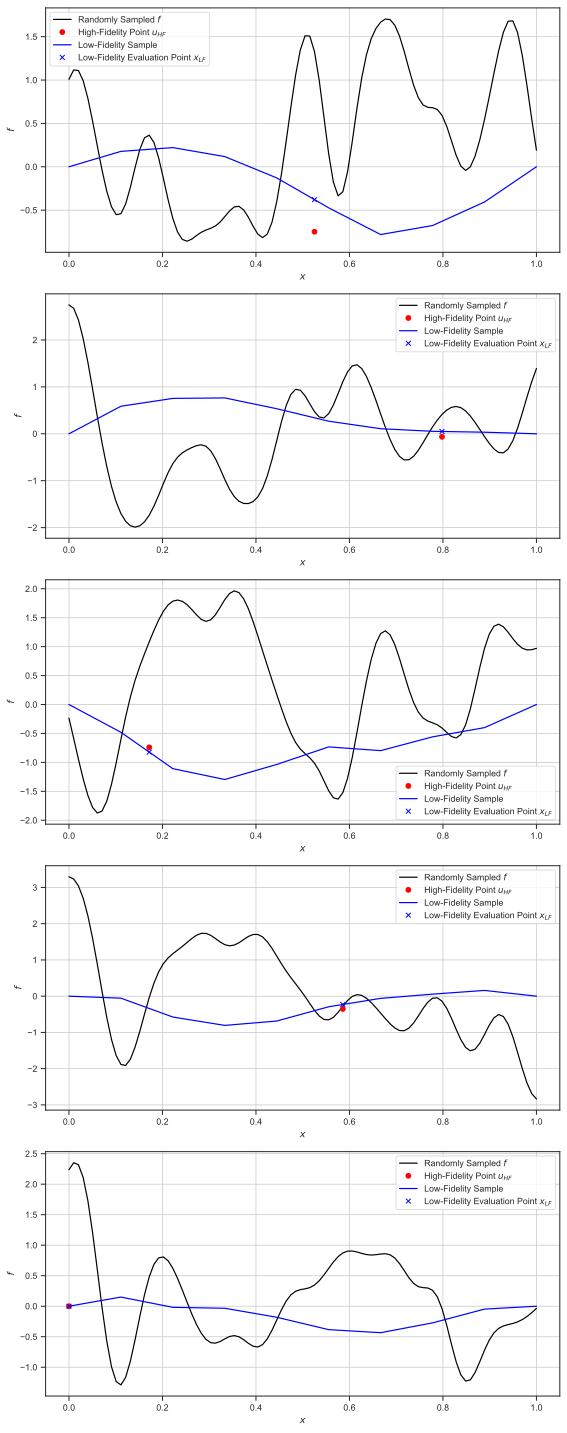

'gen_data' took 219.684159 s



In [4]:
# Generate Data
from data.poisson import gen_data

gen_data(fname="train", plot_figures=True)

In [5]:
gen_data(fname="test", plot_figures=False)

Generating operator data...


100%|██████████| 100000/100000 [00:43<00:00, 2325.49it/s]


Shape of f_{HF}: (100000, 100)
Shape of x_{HF}: (100000, 1)
Shape of u_{HF}: (100000, 1)

*************************************************



100%|██████████| 100000/100000 [00:24<00:00, 4146.39it/s]


Shape of f_{LF}: (100000, 10)
Shape of x_{LF}: (100000, 1)
Shape of u_{LF}: (100000, 100)
'gen_data' took 184.775883 s



In [6]:
from data.data_utils import get_data

fname_train = "./data/train.npz"
fname_test = "./data/test.npz"

# Residual is False
X_train, y_train, X_test, y_test = get_data(
    fname_train, fname_test, residual=False, stackbranch=False, stacktrunk=False
)

(u_train, y_train), G_train, (u_test, y_test), G_test = X_train, y_train, X_test, y_test

In [7]:
print(f"Shape of u_train: {u_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of G_train: {G_train.shape}")
print(f"Shape of u_test: {u_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of G_test: {G_test.shape}")

Shape of u_train: (500, 100)
Shape of y_train: (500, 1)
Shape of G_train: (500, 1)
Shape of u_test: (100000, 100)
Shape of y_test: (100000, 1)
Shape of G_test: (100000, 1)


In [8]:
# Residual is True
"""
1.) residual=True: Removes LF data points from HF data G_train/y_train.
2.) stackbranch=True: Horizontally Stacks Low Fidelity Data with f
3.) stacktrunk=True: Horizontaly Stacks the Low Fidelity y_train/x points with High Fidelity y_train/x_points
"""
X_train, y_train, X_test, y_test = get_data(
    fname_train, fname_test, residual=True, stackbranch=False, stacktrunk=False
)

(u_train, y_train), G_train, (u_test, y_test), G_test = X_train, y_train, X_test, y_test
print(f"Shape of u_train: {u_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of G_train: {G_train.shape}")
print(f"Shape of u_test: {u_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of G_test: {G_test.shape}")

Shape of u_train: (500, 100)
Shape of y_train: (500, 1)
Shape of G_train: (500, 1)
Shape of u_test: (100000, 100)
Shape of y_test: (100000, 1)
Shape of G_test: (100000, 1)


G_train: (500, 1)


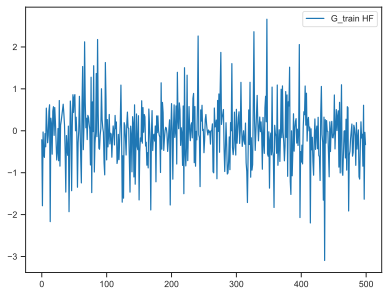

In [10]:
import numpy as np
N = 500 # High Fidelity Sample Trajectories
# i = 0
# idx = np.arange(i * N, (i + 1) * N)
idx = np.random.choice(100000, size=N, replace=False)

d = np.load(fname_train)
X_branch = d["X0"][idx] # f
X_trunk = d["X1"][idx] # x
# if stackbranch:
#     X_branch = np.hstack((d["X0"][idx], d["y_low"][idx]))
# if stacktrunk:
#     X_trunk = np.hstack((d["X1"][idx], d["y_low_x"][idx]))
X_train = (X_branch, X_trunk) #(u_train, y_train)
y_train = d["y"][idx] # u_HF # G_train
print(f"G_train: {y_train.shape}")
plt.plot(y_train, label="G_train HF")
plt.legend()
# if residual:
#     y_train -= d["y_low_x"][idx] # x_LF

G_train: (500, 1)


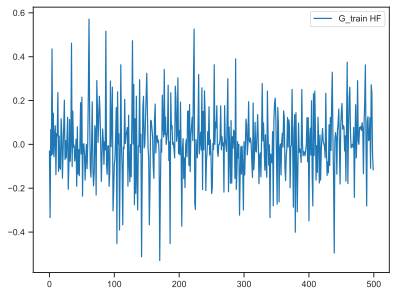

In [11]:
y_train -= d["y_low_x"][idx] # x_LF
print(f"G_train: {y_train.shape}")
plt.plot(y_train,label="G_train HF")
plt.legend()

u_train:(500, 100)


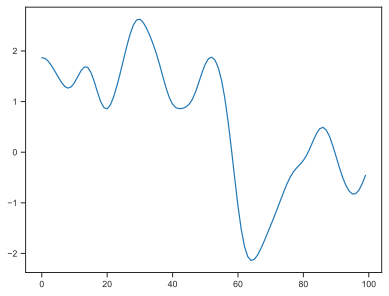

u_train after Stacking:(500, 200)


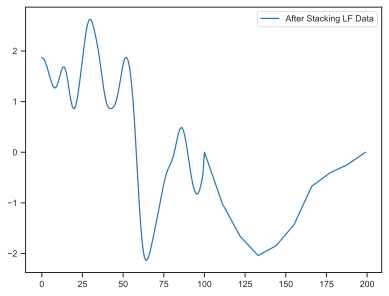

In [12]:
X_branch = d["X0"][idx] # f
print(f"u_train:{X_branch.shape}")
plt.plot(X_branch[0,:], label="u_train")
plt.show()
X_branch = np.hstack((d["X0"][idx], d["y_low"][idx]))
print(f"u_train after Stacking:{X_branch.shape}")
plt.plot(X_branch[0,:], label="After Stacking LF Data")
plt.legend()
plt.show()

y_train:(500, 1)
y_train after stacking:(500, 2)


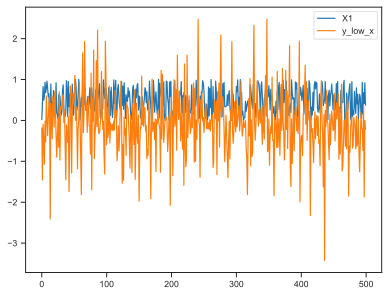

In [13]:
X_trunk = d["X1"][idx] # x
print(f"y_train:{X_trunk.shape}")
X_trunk = np.hstack((d["X1"][idx], d["y_low_x"][idx]))
print(f"y_train after stacking:{X_trunk.shape}")
plt.plot(X_trunk[:,0], label="X1")
plt.plot(X_trunk[:,1], label="y_low_x")
plt.legend()
plt.show()